In [1]:
# cell 1: Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import re

# Setup
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported!")

Libraries imported!


In [2]:
# cell 2: Load data
data_path = "/home/faiz/Documents/github/Customer_Support/data/enfuce_support_tickets_synthetic.jsonl"
df = pd.read_json(data_path, lines=True)
print(f"Data shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
df.head(3)

Data shape: (50000, 10)

Columns: ['ticket_id', 'created_at', 'channel', 'source_system', 'customer_name', 'subject', 'body', 'internal_comments', 'status', 'resolution_time_s']


,ticket_id,created_at,channel,source_system,customer_name,subject,body,internal_comments,status,resolution_time_s
0,TKT-500000,2025-08-21 09:49:57,email,EmailInbox,Sam Heikkinen,URGENT: Hitting rate limits on /transactions (...,"Hello, Hi, I'm Sam Heikkinen. My card keeps ge...",[[Agent-2] 2025-08-21 10:42 - Replied to custo...,in_progress,NaN
1,TKT-500001,2025-10-05 11:06:35,api,Zendesk,Alex Mäkinen,Question about KYC — documents keep getting re...,"Hi team, Hi, I'm Alex Mäkinen. My card keeps g...",[[Agent-1] 2025-10-05 12:47 - No incident on s...,closed,41249.0
2,TKT-500002,2025-08-31 17:06:37,email,Zendesk,Jamie Salonen,Can’t pay online — keeps declining 😕,"Hi team, Hi, I'm Jamie Salonen. Not sure if th...",[[Agent-2] 2025-08-31 17:54 - Awaiting custome...,waiting_on_customer,NaN


Detecting languages...


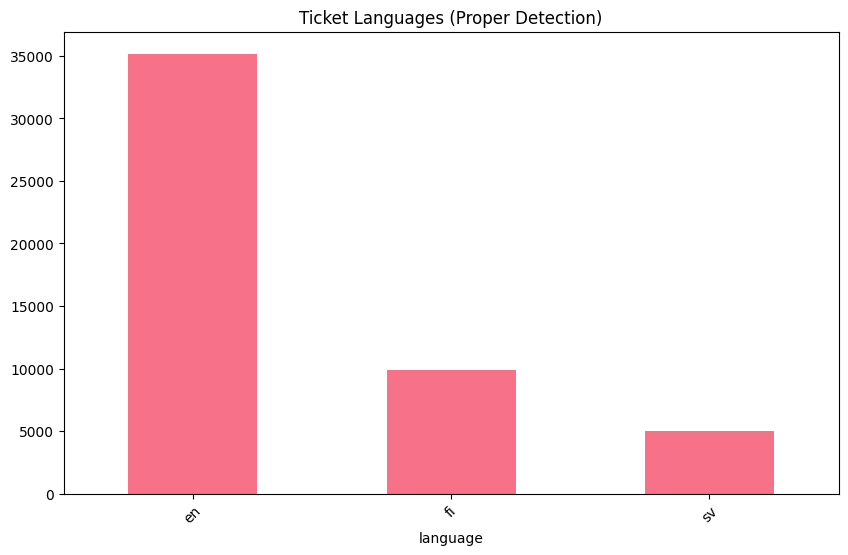

Language distribution:
language
en    35179
fi     9846
sv     4975
Name: count, dtype: int64


In [3]:
# cell 3: Better language detection
def detect_language_smart(text):
    if pd.isna(text) or text == '':
        return 'unknown'
    lang = detect(str(text))
    if lang == "no" or lang == "de":
        lang = "sv"
    return lang


# Sample for speed (optional - remove for full dataset)
sample_df = df

print("Detecting languages...")
sample_df['language'] = sample_df['body'].apply(detect_language_smart)

# Language distribution
lang_counts = sample_df['language'].value_counts().head(10)
plt.figure(figsize=(10, 6))
lang_counts.plot(kind='bar')
plt.title('Ticket Languages (Proper Detection)')
plt.xticks(rotation=45)
plt.show()

print("Language distribution:")
print(lang_counts)

In [4]:
sammm = sample_df[sample_df["language"]=="sv"]
sammm["body"].iloc[1]

"Hej där, Hi, I'm Sofia Ahonen. Mitt kort blir felar när jag försöker betala. Säg till om ni behöver skärmdumpar. Email: sofia.ahonen@company.fi IBAN: FI2336941506293794 Card: 5500 0000 0000 0004 As mentioned earlier, this is blocking our checkout. Lansering imorgon, lite bråttom. Tack!"

Detecting PII...


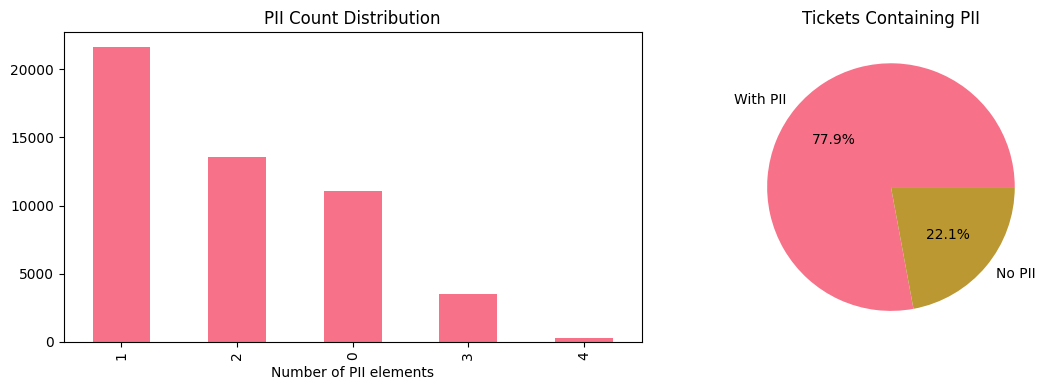

Tickets with PII: 38956 (77.9%)
Max PII in single ticket: 4


In [4]:
# cell 4: Better PII detection
import re

def detect_pii_robust(text):
    if pd.isna(text):
        return 0
    
    text = str(text)
    pii_patterns = [
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',  # Email
        r'\b\d{4}[-\s]?\d{4}[-\s]?\d{4}[-\s]?\d{4}\b',  # Card numbers
        r'\bFI\d{16,18}\b',  # IBAN (more flexible)
        r'\+\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,9}\b',  # International phones
    ]
    
    total_pii = 0
    for pattern in pii_patterns:
        total_pii += len(re.findall(pattern, text))
    
    return total_pii

print("Detecting PII...")
df['pii_count'] = df['body'].apply(detect_pii_robust)

# PII analysis
pii_stats = df['pii_count'].describe()
pii_tickets = (df['pii_count'] > 0).sum()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['pii_count'].value_counts().head(10).plot(kind='bar')
plt.title('PII Count Distribution')
plt.xlabel('Number of PII elements')

plt.subplot(1, 2, 2)
plt.pie([pii_tickets, len(df) - pii_tickets], 
        labels=['With PII', 'No PII'], 
        autopct='%1.1f%%')
plt.title('Tickets Containing PII')

plt.tight_layout()
plt.show()

print(f"Tickets with PII: {pii_tickets} ({pii_tickets/len(df)*100:.1f}%)")
print(f"Max PII in single ticket: {df['pii_count'].max()}")

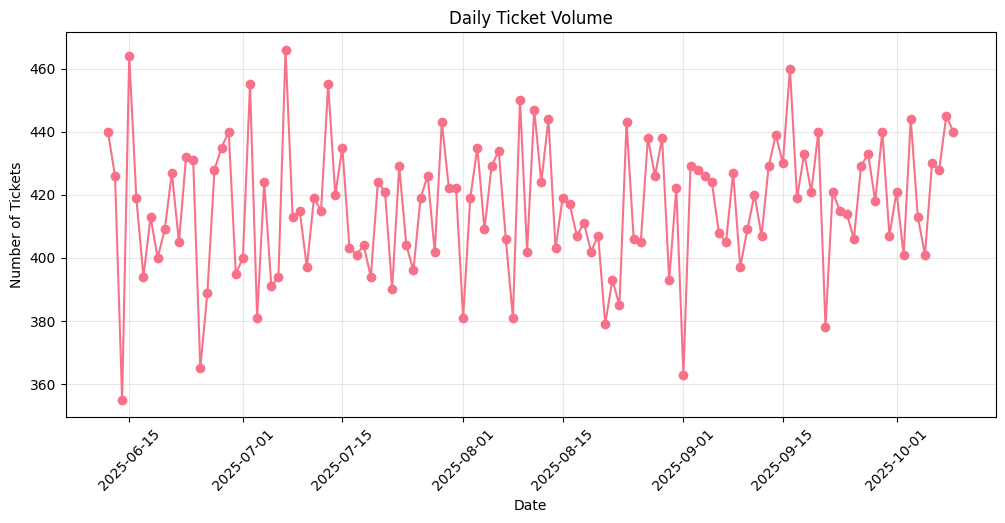

Date range: 2025-06-12 07:00:41 to 2025-10-09 22:59:40
Total days: 119
Average daily tickets: 420.2


In [5]:
# cell 5: Ticket volume over time
df['created_at'] = pd.to_datetime(df['created_at'])
df['created_date'] = df['created_at'].dt.date

# Daily volume
daily_volume = df['created_date'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(daily_volume.index, daily_volume.values, marker='o')
plt.title('Daily Ticket Volume')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Date range: {df['created_at'].min()} to {df['created_at'].max()}")
print(f"Total days: {(df['created_at'].max() - df['created_at'].min()).days}")
print(f"Average daily tickets: {len(df) / ((df['created_at'].max() - df['created_at'].min()).days):.1f}")

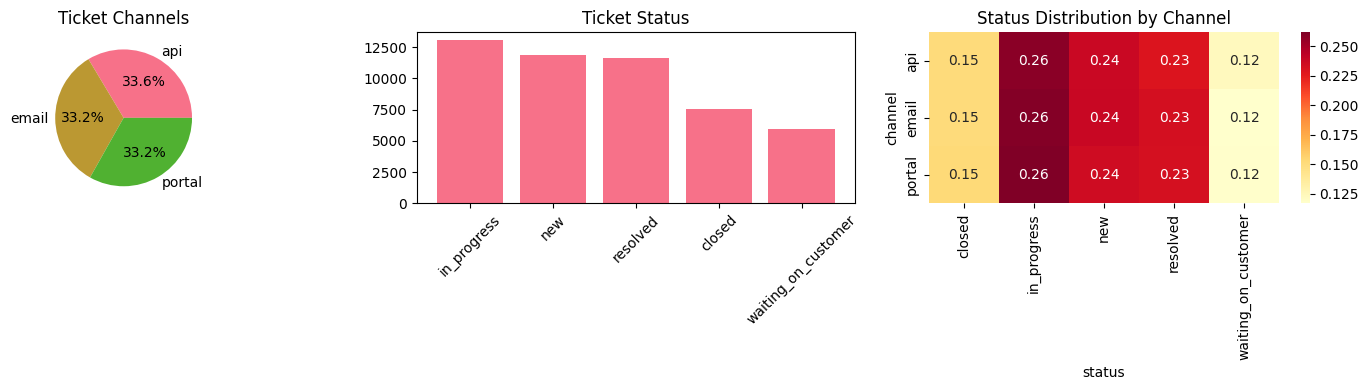

Most common channel: api
Most common status: in_progress


In [6]:
# cell 6: Channel and status analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Channel distribution
channel_counts = df['channel'].value_counts()
axes[0].pie(channel_counts.values, labels=channel_counts.index, autopct='%1.1f%%')
axes[0].set_title('Ticket Channels')

# Status distribution
status_counts = df['status'].value_counts()
axes[1].bar(status_counts.index, status_counts.values)
axes[1].set_title('Ticket Status')
axes[1].tick_params(axis='x', rotation=45)

# Channel vs Status
status_by_channel = pd.crosstab(df['channel'], df['status'], normalize='index')
sns.heatmap(status_by_channel, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[2])
axes[2].set_title('Status Distribution by Channel')

plt.tight_layout()
plt.show()

print("Most common channel:", channel_counts.index[0])
print("Most common status:", status_counts.index[0])

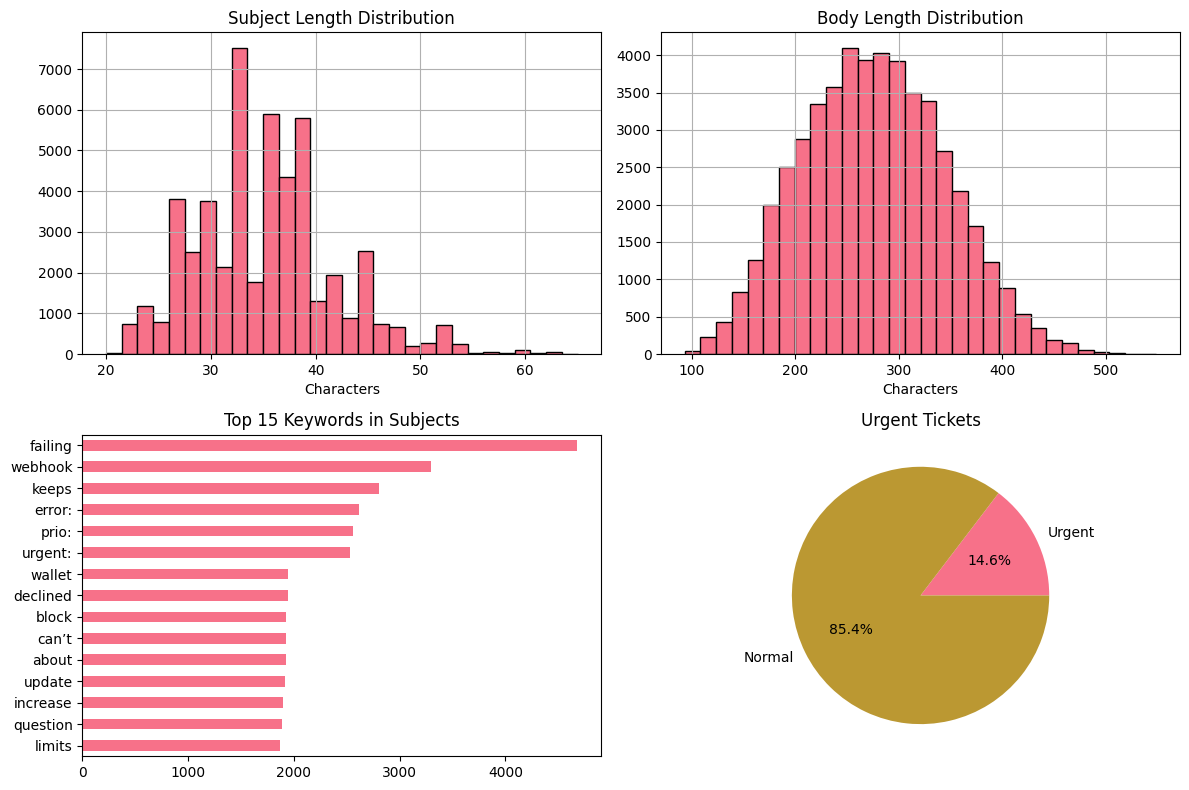

Urgent tickets: 7317 (14.6%)
Average subject length: 34.9 chars


In [7]:
# cell 7: Text analysis for categorization
# Subject length analysis
df['subject_length'] = df['subject'].str.len()
df['body_length'] = df['body'].str.len()

# Common keywords in subjects (for topic discovery)
all_subjects = ' '.join(df['subject'].dropna().astype(str).str.lower())
words = [word for word in all_subjects.split() if len(word) > 4]  # Filter short words
word_freq = pd.Series(words).value_counts().head(15)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
df['subject_length'].hist(bins=30, edgecolor='black')
plt.title('Subject Length Distribution')
plt.xlabel('Characters')

plt.subplot(2, 2, 2)
df['body_length'].hist(bins=30, edgecolor='black')
plt.title('Body Length Distribution')
plt.xlabel('Characters')

plt.subplot(2, 2, 3)
word_freq.plot(kind='barh')
plt.title('Top 15 Keywords in Subjects')
plt.gca().invert_yaxis()

plt.subplot(2, 2, 4)
# Priority detection
df['has_urgent'] = df['subject'].str.contains(r'URGENT|PRIO|CRITICAL', case=False, na=False)
urgent_count = df['has_urgent'].sum()
plt.pie([urgent_count, len(df)-urgent_count], 
        labels=['Urgent', 'Normal'], 
        autopct='%1.1f%%')
plt.title('Urgent Tickets')

plt.tight_layout()
plt.show()

print(f"Urgent tickets: {urgent_count} ({urgent_count/len(df)*100:.1f}%)")
print(f"Average subject length: {df['subject_length'].mean():.1f} chars")

In [8]:
# cell 8: Key insights summary
print("=== KEY INSIGHTS FOR TICKET CATEGORIZATION ===")
print(f"1. SCALE: {len(df):,} tickets to analyze")
print(f"2. LANGUAGES: Need multilingual support (mainly {', '.join(lang_counts.index[:3].astype(str))})")
print(f"3. PII: {pii_tickets/len(df)*100:.1f}% tickets contain sensitive data - needs masking")
print(f"4. CHANNELS: {channel_counts.index[0]} is main channel ({channel_counts.iloc[0]/len(df)*100:.1f}%)")
print(f"5. URGENCY: {urgent_count} urgent tickets need prioritization")
print(f"6. TEXT: Avg {df['subject_length'].mean():.0f} chars in subject, {df['body_length'].mean():.0f} in body")

print("\n=== RECOMMENDATIONS ===")
print("✓ Use proper language detection for routing")
print("✓ Implement PII masking before processing") 
print("✓ Build channel-specific models")
print("✓ Create urgency detection from subjects")
print("✓ Use text length for complexity estimation")

=== KEY INSIGHTS FOR TICKET CATEGORIZATION ===
1. SCALE: 50,000 tickets to analyze
2. LANGUAGES: Need multilingual support (mainly en, fi, sv)
3. PII: 77.9% tickets contain sensitive data - needs masking
4. CHANNELS: api is main channel (33.6%)
5. URGENCY: 7317 urgent tickets need prioritization
6. TEXT: Avg 35 chars in subject, 276 in body

=== RECOMMENDATIONS ===
✓ Use proper language detection for routing
✓ Implement PII masking before processing
✓ Build channel-specific models
✓ Create urgency detection from subjects
✓ Use text length for complexity estimation
